In [80]:
import sys

import clip
import gradio as gr
import hydra
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import train
import yaml
from dalle2_pytorch import DiffusionPriorNetwork
from omegaconf import DictConfig, OmegaConf
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from tqdm.auto import tqdm

sys.path.append("stylegan3")
import dnnlib
import legacy
from clip2latent import train_utils
from clip2latent.latent_prior import ZWPrior
from clip2latent.train_utils import (compute_val, denormalise_data, make_grid,
                                     make_image_val_data, make_text_val_data, normalise_data)

# checkpoint = "/home/jpinkney/code/clip2latent/outputs/2022-05-18/03-53-19/checkpoints/20220518-035604/000625.ckpt"
checkpoint = "/home/jpinkney/code/clip2latent/outputs/2022-05-21/15-40-12/checkpoints/20220521-154047/000550.ckpt"
use_ema = True
device = "cuda:0"
data = torch.load(checkpoint, map_location="cpu")
# cfg = data["cfg"]
cfg_file = "/home/jpinkney/code/clip2latent/outputs/2022-05-21/15-40-12/.hydra/config.yaml"
cfg = OmegaConf.load(cfg_file)
print(cfg)

print(f"loading diffusion model")
prior_network = DiffusionPriorNetwork(**cfg["model"]["network"]).to(device)
diffusion_prior = ZWPrior(prior_network, **cfg["model"]["diffusion"]).to(device)
state_dict = data["state_dict"]
if use_ema:
    ema_key = "ema_diffusion_prior.ema_model."
    prior_dict = {k.replace(ema_key,""): v for k,v in state_dict.items() if k.startswith(ema_key)}
diffusion_prior.load_state_dict(prior_dict)

print("loading generator")
# Load eval models
with dnnlib.util.open_url(cfg["data"]["sg_pkl"]) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

print("loading clip")
clip_model, _ = clip.load(cfg["data"]["clip_variant"], device=device)

print("done")
# FIXME
# w = torch.load(hydra.utils.to_absolute_path(cfg["data"]["latent_path"]))
# stats = {
        # "w": train_utils.make_data_stats(w),
    # }
stats, _ = train.load_data(cfg["data"])
n_samples = 2

@torch.no_grad()
def greet(text_samples, cond_scale):
    diffusion_prior.eval()
    images = []
    text = clip.tokenize(text_samples).to(device)
    text_features = clip_model.encode_text(text)
    out = diffusion_prior.p_sample_loop((n_samples, 512), {"text_embed": text_features.tile(n_samples, 1)}, cond_scale=cond_scale)
    normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

    pred_w_clip_features = []
    pred_w = denormalise_data(out, *stats["w"])
    for w in tqdm(pred_w):
        out = G.synthesis(w.tile(1,18,1))
        images.append(out)
        clip_in = 0.5*F.interpolate(out, (224,224), mode="area") + 0.5
        image_features = clip_model.encode_image(normalize(clip_in))
        pred_w_clip_features.append(image_features)

    pred_w_clip_features = torch.cat(pred_w_clip_features, dim=0)
    sim = torch.cosine_similarity(pred_w_clip_features, text_features)
    sim, idxs = torch.sort(sim, descending=True)
    images = torch.cat(images, dim=0)
    images = images[idxs, ...]
    print(sim)

    grid = train_utils.make_grid(images)

    return grid

{'model': {'network': {'dim': 512, 'num_timesteps': 1000, 'depth': 12, 'dim_head': 64, 'heads': 12}, 'diffusion': {'image_embed_dim': 512, 'timesteps': 1000, 'cond_drop_prob': 0.2, 'image_embed_scale': 1.0, 'beta_schedule': 'cosine', 'predict_x_start': True}}, 'device': 'cuda:0', 'data': {'bs': 512, 'format': 'webdataset', 'path': 'data/webdataset/sg2-ffhq-1024-clip/{00000..99}.tar', 'noise_scale': 0.75, 'sg_pkl': 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-1024x1024.pkl', 'clip_variant': 'ViT-B/32'}, 'val': {'n_im_val_samples': 16, 'text_val_samples': ["A photograph of a young man's with a beard", "A photograph of a old woman's face with grey hair", 'A photograph of a child at a birthday party', 'A picture of a face outside in bright sun in front of green grass', 'This man has bangs arched eyebrows curly hair and a small nose', 'A photo of Barack Obama', 'An arctic explorer', "A clown's face covered in make up"]}, 'train': {'loop': {

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


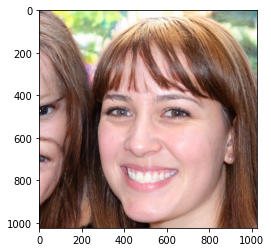

In [202]:
import matplotlib.pyplot as plt

z = torch.randn(4, 512, device=device)
with torch.no_grad():
    orig_w = G.mapping(z, c=None)
    out = G.synthesis(orig_w)
start_im = out[0].cpu().permute(1,2,0)*0.5 + 0.5
plt.imshow(start_im)
plt.show()

In [215]:
start_t = 200
t = torch.tensor([start_t], device = device, dtype = torch.long)
orig_w_norm = normalise_data(orig_w[0,0,:], *stats["w"])
noised = diffusion_prior.q_sample(orig_w_norm, t).unsqueeze(0).tile(2,1)
print(noised.shape)

skip = 1
@torch.no_grad()
def p_sample_loop(prior, shape, text_cond, cond_scale = 1.):
    device = prior.betas.device

    b = shape[0]
    image_embed = noised

    if prior.init_image_embed_l2norm:
        image_embed = l2norm(image_embed) * prior.image_embed_scale

    for i in tqdm(reversed(range(0, start_t, skip)), desc='sampling loop time step', total=prior.num_timesteps//skip):
        times = torch.full((b,), i, device = device, dtype = torch.long)
        image_embed = prior.p_sample(image_embed, times, text_cond = text_cond, cond_scale = cond_scale)

    return image_embed


torch.Size([2, 512])


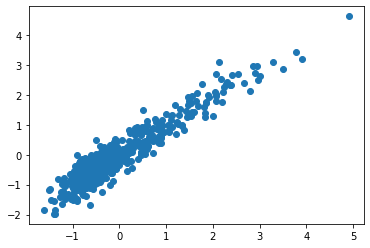

In [216]:
plt.scatter(orig_w_norm.cpu(), noised[0].cpu())
plt.show()

In [217]:
# with torch.no_grad():
#     emb = denormalise_data(noised, *stats["w"])
#     out = G.synthesis(emb.unsqueeze(1).tile(1,18,1))
# im = out[0].cpu().permute(1,2,0)*0.5 + 0.5
# plt.imshow(im)
# plt.show()

sampling loop time step:  20%|█████████████████████████████████████▊                                                                                                                                                       | 200/1000 [00:04<00:19, 40.89it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


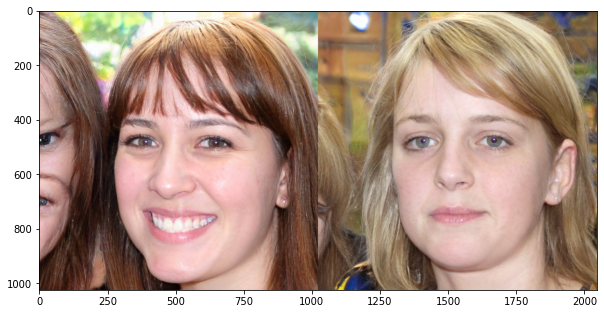

In [232]:
text_samples = "A photo of a bored sad woman with plantinum blonde hair"
text = clip.tokenize(text_samples).to(device)
text_features = clip_model.encode_text(text)
emb = p_sample_loop(diffusion_prior, (n_samples, 512), {"text_embed": text_features.tile(n_samples, 1)}, cond_scale=4)

with torch.no_grad():
    emb = denormalise_data(emb, *stats["w"])
    out = G.synthesis(emb.unsqueeze(1).tile(1,18,1))
    
im = out[0].cpu().permute(1,2,0)*0.5 + 0.5
im = np.concatenate((start_im, im), axis=1)
plt.figure(figsize=(10,10))
plt.imshow(im)
plt.show()